In [19]:
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
pd.set_option('Display.max_columns',None)
import matplotlib.pyplot as plt
import pickle
from scipy.signal import savgol_filter
monkey_name = 'thina'
if monkey_name=='nana':
    df = pd.read_csv('../data_csv/FinalDfNana_aligned.csv')
else:
    df = pd.read_csv('../data_csv/FinalDfThina_aligned.csv')

Number of trials with updTime: 2169

Trajectory 9324:
Number of points: 153
X range: -0.12 - 1.24
Y range: 0.00 - 1.61
Z range: 0.00 - 3.32
closest index is 1043846
closest time is 2.02
x: -0.01
y: 0.05
z: 0.04

Trajectory 12600:
Number of points: 147
X range: -1.29 - 0.83
Y range: -0.04 - 1.17
Z range: -2.42 - 2.67
closest index is 1390920
closest time is 1.64
x: -0.16
y: -0.03
z: -0.08


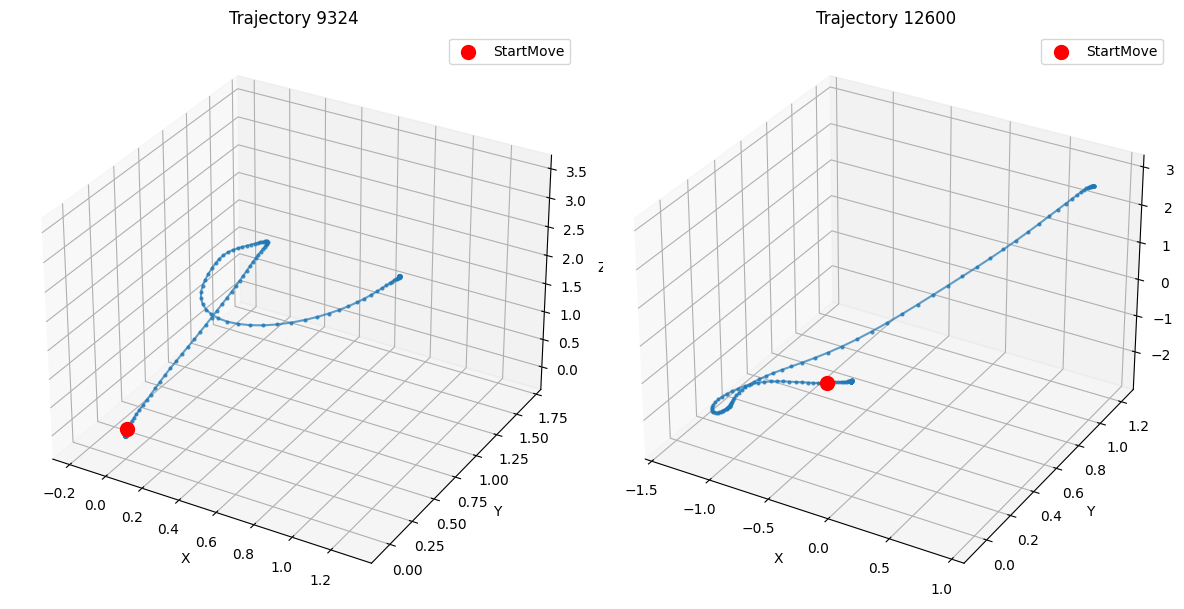

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to plot a trajectory with automatic axis adjustment
def plot_trajectory(ax, df_plot):
    # Plot the trajectory
    ax.plot(df_plot['x'], df_plot['y'], df_plot['z'], marker='o', alpha=0.7, markersize=2, linewidth=1.5)
    
    # Calculate axis limits based on actual data with small margins
    x_margin = (df_plot['x'].max() - df_plot['x'].min()) * 0.1 if df_plot['x'].max() != df_plot['x'].min() else 1
    y_margin = (df_plot['y'].max() - df_plot['y'].min()) * 0.1 if df_plot['y'].max() != df_plot['y'].min() else 1
    z_margin = (df_plot['z'].max() - df_plot['z'].min()) * 0.1 if df_plot['z'].max() != df_plot['z'].min() else 1
    
    ax.set_xlim(df_plot['x'].min() - x_margin, df_plot['x'].max() + x_margin)
    ax.set_ylim(df_plot['y'].min() - y_margin, df_plot['y'].max() + y_margin)
    ax.set_zlim(df_plot['z'].min() - z_margin, df_plot['z'].max() + z_margin)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Add updTime point if available
    if pd.notna(df_plot['updTime'].iloc[0]) and pd.notna(df_plot['update_time'].iloc[0]):
        try:
            closesnt_index = np.abs(df_plot['time_milisecond'] - (df_plot['RTu'].iloc[0]+df_plot['go_time'].iloc[0])).idxmin()
            print(f'closest index is {closesnt_index}')
            print(f'closest time is {df_plot["time_milisecond"].loc[closesnt_index]:.2f}')
            print(f'x: {df_plot["x"].loc[closesnt_index]:.2f}')
            print(f'y: {df_plot["y"].loc[closesnt_index]:.2f}')
            print(f'z: {df_plot["z"].loc[closesnt_index]:.2f}')
            ax.scatter(df_plot['x'].loc[closesnt_index], 
                      df_plot['y'].loc[closesnt_index], 
                      df_plot['z'].loc[closesnt_index], 
                      color='red', s=100, label='StartMove', alpha=1)
            ax.legend()
        except Exception as e:
            print(f"Error adding updTime point: {e}")

ids_with_updTime = df.loc[df['updTime'].notna(), 'id'].unique()
print(f"Number of trials with updTime: {len(ids_with_updTime)}")


id_for_plot = np.random.choice(ids_with_updTime, size=2, replace=False)


# Create subplots
fig = plt.figure(figsize=(12,6))

for i, idx in enumerate(id_for_plot):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    # Extract the DataFrame for the current trajectory
    df_plot = df[df['id'] == idx]
    
    print(f"\nTrajectory {idx}:")
    print(f"Number of points: {len(df_plot)}")
    print(f"X range: {df_plot['x'].min():.2f} - {df_plot['x'].max():.2f}")
    print(f"Y range: {df_plot['y'].min():.2f} - {df_plot['y'].max():.2f}")
    print(f"Z range: {df_plot['z'].min():.2f} - {df_plot['z'].max():.2f}")
    
    plot_trajectory(ax, df_plot)
    ax.set_title(f'Trajectory {idx}')

plt.tight_layout()
plt.show()


In [21]:
#4. Compute velocity and update movement times
def process_dataframe(len_df):
    """
    Create processed df.
    """
    process_df = []
    for trial_id in len_df['id'].unique():
        trial = process_trial(len_df, trial_id)
        process_df.append(trial)
    process_df = pd.concat(process_df, ignore_index=True)
    return process_df

def process_trial(df, trial_id):
    """
    Process a single trial by updating columns, computing velocity, and updating movement times.
    """
    trajectory = df[df['id'] == trial_id].copy() #all data points with the same id
    trajectory['time_milisecond'] *= 1000
    trajectory['cue_milisecond'] = trajectory.iloc[0]['cue_time'] * 1000
    trajectory['go_milisecond'] = trajectory.iloc[0]['go_time'] * 1000
    
    zero_init_cols = ['cue2go_milisecond', 'update_milisecond','go2update_milisecond','start_movement_miliseconds','end_movement_miliseconds',
                      'movement_duration_miliseconds','is_update','is_turn']
    df[zero_init_cols] = 0
    
    if not pd.isna(trajectory['RTu'].iloc[0]):
        # Case 1: Update trajectory
        trajectory['cue2go_milisecond'] = trajectory.iloc[0]['Cue2GoU'] * 1000
        trajectory['update_milisecond'] = trajectory.iloc[0]['update_time'] * 1000
        trajectory['go2update_milisecond'] = trajectory.iloc[0]['Go2U'] * 1000
        trajectory['start_movement_miliseconds'] = trajectory.iloc[0]['RTu'] * 1000 + trajectory.iloc[0]['go_milisecond']
        trajectory['end_movement_miliseconds'] = trajectory.iloc[0]['MTu'] * 1000 + trajectory.iloc[0]['start_movement_miliseconds']
        trajectory['movement_duration_miliseconds'] = trajectory.iloc[0]['MTu'] * 1000
        trajectory['is_update'] = 1
        if not (np.isnan(trajectory['updTime'].iloc[0]) or trajectory['updTime'].iloc[0] == -100): 
            # Case 1.1: Trajectory with turn ("stop time present")
            trajectory['stop_turn_miliseconds'] = trajectory.iloc[0]['updTime'] * 1000 + trajectory.iloc[0]['update_milisecond']
            trajectory['is_turn'] = 1
        else: 
            # Case 1.2: Trajectory without turn ("No stop time")
            trajectory['is_turn'] = 0
    else:
        # Case 2: No update trajectory
        trajectory['update_milisecond'] = np.nan
        trajectory['go2update_milisecond'] = np.nan 
        trajectory['cue2go_milisecond'] = trajectory.iloc[0]['Cue2Go'] * 1000
        trajectory['start_movement_miliseconds'] = trajectory.iloc[0]['RT'] * 1000 + trajectory.iloc[0]['go_milisecond']
        trajectory['end_movement_miliseconds'] = trajectory.iloc[0]['MT'] * 1000 + trajectory.iloc[0]['start_movement_miliseconds']
        trajectory['movement_duration_miliseconds'] = trajectory.iloc[0]['MT'] * 1000
        trajectory['is_update'] = 0
        trajectory['is_turn'] = 0
  
    trajectory = compute_velocities_3d(trajectory, trajectory.iloc[0]['cue_time'] * 1000)
    return trajectory

def compute_3_point_angles(df):
    """
    Calculate angle between every 3 consecutive points.
    """
    p1 = df[['x', 'y', 'z']].shift(1)
    p2 = df[['x', 'y', 'z']]
    p3 = df[['x', 'y', 'z']].shift(-1)
    
    v1 = p2 - p1  # vector from previous to current
    v2 = p3 - p2  # vector from current to next
    
    # Dot product and norms
    dot_product = (v1 * v2).sum(axis=1)
    norm_v1 = np.linalg.norm(v1, axis=1)
    norm_v2 = np.linalg.norm(v2, axis=1)
    
    # Prevent division by zero
    norms = norm_v1 * norm_v2
    norms = np.where(norms == 0, 1e-10, norms)
    
    cos_angle = np.clip(dot_product / norms, -1.0, 1.0)
    angles = np.arccos(cos_angle)  # in radians
    
    return angles

def compute_velocities_3d(df, signal_cue):
    """
    Calculate velocity post-signal cue, including 3D data (x, y, z).
    """
    # Filter and calculate differences
    df_filtered = df[df['time_milisecond'] >= signal_cue].copy()
    dx = df_filtered['x'].diff()
    dy = df_filtered['y'].diff()
    dz = df_filtered['z'].diff()  # Include z-axis differences
    dt = df_filtered['time_milisecond'].diff()

    # Compute 3D velocity while avoiding division by zero
    df_filtered['velocity'] = np.sqrt(dx**2 + dy**2 + dz**2) / (dt + 1e-10)
    
    # Compute 3D direction (azimuth and elevation)
    df_filtered['azimuth'] = np.arctan2(dy, dx)
    df_filtered['elevation'] = np.arctan2(dz, np.sqrt(dx**2 + dy**2))
    df_filtered = df_filtered.dropna(subset=['azimuth', 'elevation'])

    
    # Unwrapping the azimuth and elevation for angular calculations
    df_filtered['azimuth_unwrapped'] = np.unwrap(df_filtered['azimuth'])
    df_filtered['elevation_unwrapped'] = np.unwrap(df_filtered['elevation'])
    
    # Turning angle in azimuth and elevation
    df_filtered['turning_angle_azimuth'] = df_filtered['azimuth_unwrapped'].diff().fillna(0)
    df_filtered['turning_angle_elevation'] = df_filtered['elevation_unwrapped'].diff().fillna(0)

    #compute 3-point angles
    df_filtered['three_point_angle'] = compute_3_point_angles(df_filtered)

    
    # 3D curvature calculation
    ddx = dx.diff().fillna(0)
    ddy = dy.diff().fillna(0)
    ddz = dz.diff().fillna(0)
    
    df_filtered['curvature'] = (
        np.sqrt((ddy * dz - ddz * dy)**2 + (ddz * dx - ddx * dz)**2 + (ddx * dy - ddy * dx)**2)
        / (np.power(dx**2 + dy**2 + dz**2, 1.5) + 1e-10))

    return df_filtered.iloc[1:]  # skip the first NaN result from diff()
processed_df = process_dataframe(df)
processed_df = processed_df.dropna(subset=['three_point_angle'])


In [22]:
def filtering_by_reactiontime(df):
    def condition(group):
        return ((pd.isna(group['RT']).all() and (-0.320 <= group['RTu']).all() and (group['RTu'] <= 0.5).all()) or
            (pd.isna(group['RTu']).all() and (-0.2 <= group['RT']).all() and (group['RT'] <= 0.5).all()))
    # Group by 'id' and apply the condition to each group
    return df.groupby('id').filter(condition)
df_reaction_time = filtering_by_reactiontime(processed_df)

def filter_by_movement_duration(df, max_duration=1200):
    # Apply the filtering condition at the trial level
    return df.groupby('id').filter(lambda group: group['movement_duration_miliseconds'].max() <= max_duration)
df_movement_reaction_time = filter_by_movement_duration(df_reaction_time)

In [23]:
def window_and_normalize_trial(trial, right_window=1500, left_window=200):
    """
    Process and window a single trial.
    """
    signal_go = trial.iloc[0]['go_milisecond']

    # Determine the window around the go signal
    window_start = signal_go - left_window
    window_end = signal_go + right_window
    # Filter the trial to the specified window
    windowed_trial = trial[(trial['time_milisecond'] >= window_start) & (trial['time_milisecond'] <= window_end)].copy()
    new_start_time = windowed_trial.iloc[0]['time_milisecond']

    # Adjust times to start from zero within the window
    windowed_trial['adjusted_time'] = windowed_trial['time_milisecond'] - new_start_time

    # Normalize the adjusted times
    max_adjusted_time = windowed_trial['adjusted_time'].max()
    windowed_trial['normalized_time'] = windowed_trial['adjusted_time'] / max_adjusted_time

    # Use precomputed movement start and end times from the previous processing
    start_movement_time = trial['start_movement_miliseconds'].iloc[0] - new_start_time
    windowed_trial['adjusted_start_movement'] = start_movement_time
    windowed_trial['normalized_start_movement'] = start_movement_time / max_adjusted_time

    if not np.isnan(trial['updTime'].iloc[0]): #Turn & Update
        stop_turn_time = trial['stop_turn_miliseconds'].iloc[0] - new_start_time
        windowed_trial['adjusted_stop_turn'] = stop_turn_time
        windowed_trial['normalized_stop_turn'] = stop_turn_time / max_adjusted_time

    return windowed_trial

def window_trials(processed_df, right_window=1000, left_window=500):
    """
    Adjust times for each trial in the processed DataFrame.
    """
    # Apply the function to all trials in the dataframe
    windowed_trials = []
    for trial_id in processed_df['id'].unique():
        trial = processed_df[processed_df['id'] == trial_id]
        windowed_trial = window_and_normalize_trial(trial, right_window, left_window)
        windowed_trials.append(windowed_trial)
    return pd.concat(windowed_trials, ignore_index=True)

# Example usage
df_windowed = window_trials(df_movement_reaction_time)
df_windowed = df_windowed.reset_index(drop=True)

In [24]:
row = df_windowed.loc[df_windowed['normalized_start_movement'].idxmin()]
print(row)
print(f"min normalized start movement: {row['normalized_start_movement']:.2f}")
print(f"max normalized start movement: {df_windowed['normalized_start_movement'].max():.2f}")

time_milisecond              583.451477
x                              0.000164
y                             -0.004581
z                              0.003854
velocity                        0.00041
                                ...    
normalized_time                     0.0
adjusted_start_movement       66.680169
normalized_start_movement      0.062016
adjusted_stop_turn                  NaN
normalized_stop_turn                NaN
Name: 1112347, Length: 64, dtype: object
min normalized start movement: 0.06
max normalized start movement: 0.93


In [25]:
from scipy.signal import savgol_filter
def apply_smoothing_3d(group, col_x='x', col_y='y',col_z='z',window_length=5, poly_order=1):
    """
    Applies Savitzky-Golay smoothing to specified columns in a DataFrame group.
    """
    # Apply the Savitzky-Golay filter
    x_smooth = savgol_filter(group[col_x], window_length, poly_order)
    y_smooth = savgol_filter(group[col_y], window_length, poly_order)
    z_smooth = savgol_filter(group[col_z], window_length, poly_order)

    # Add smoothed data to new columns
    group['smooth_x'] = x_smooth
    group['smooth_y'] = y_smooth
    group['smooth_z'] = z_smooth
    return group


#7. Apply smoothing to each group in the DataFrame
df_smooth = df_windowed.groupby('id').apply(apply_smoothing_3d)
df_smooth = df_smooth.reset_index(drop=True)

/var/folders/_g/3z75f6712896hmqgg1jt1t9h0000gn/T/ipykernel_80000/638509315.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smooth = df_windowed.groupby('id').apply(apply_smoothing_3d)


In [26]:
def recenter_trajectory_3d(group):
    """
    Recenters a trajectory group by subtracting the coordinates at the start movement time.
    """

    initial_x_offset = group['smooth_x'].iloc[0]
    initial_y_offset = group['smooth_y'].iloc[0]
    initial_z_offset = group['smooth_z'].iloc[0]

    # Apply the offset to recenter the trajectory
    group['centered_x'] = group['smooth_x'] - initial_x_offset
    group['centered_y'] = group['smooth_y'] - initial_y_offset
    group['centered_z'] = group['smooth_z'] - initial_z_offset
    return group

# Apply the recentering transformation to each trajectory 
df_centered = df_smooth.groupby('id').apply(recenter_trajectory_3d)


/var/folders/_g/3z75f6712896hmqgg1jt1t9h0000gn/T/ipykernel_80000/2615706821.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_centered = df_smooth.groupby('id').apply(recenter_trajectory_3d)


In [27]:
df_centered['id'] = df_centered['id'].astype(int)
df_centered = df_centered.reset_index(drop=True)

In [28]:

def apply_rotation_3d(group):
    """
    Applies rotation and reflection transformations to 3D trajectory data.
    """
    # Extract target ID from the first row of the group
    id_target = group.iloc[0]['id_target']

    # Initialize target angles for rotation
    target_angles = {1: 270, 2: 315, 3: 0, 4: 45, 5: 90, 6: 135, 7: 180, 8: 225}

    # Check for updates and obtain update target ID if present
    is_updated = not pd.isna(group.iloc[0]['id_update'])
    id_target_update = group.iloc[0]['id_update'] if is_updated else None

    if id_target == 5:
        if is_updated and (id_target_update > id_target):
            # Reflect over the Y-axis if movement is not clockwise
            group['rotation_x'], group['rotation_y'], group['rotation_z'] = -group['centered_x'], group['centered_y'], group['centered_z']
        else:
            # No rotation needed
            group['rotation_x'], group['rotation_y'], group['rotation_z'] = group['centered_x'], group['centered_y'], group['centered_z']
    else:
        # General case for all other targets
        rotation_angle = 90 - target_angles[id_target] 
        # Rotate coordinates based on computed angle
        group['rotation_x'], group['rotation_y'], group['rotation_z'] = rotate_trajectory_3d(
            group['centered_x'], group['centered_y'], group['centered_z'], rotation_angle
        )
        if is_updated and (id_target_update > id_target):
            # Reflect over the Y-axis if movement is not clockwise
            group['rotation_x'], group['rotation_y'], group['rotation_z'] = -group['rotation_x'], group['rotation_y'], group['rotation_z']

    return group

def rotate_trajectory_3d(x, y, z, angle):
    """
    Rotates a 3D point around the Z-axis by a specified angle.
    This assumes a rotation in the XY plane (around the Z-axis).
    """
    angle_rad = np.radians(angle)
    x_new = x * np.cos(angle_rad) - y * np.sin(angle_rad)
    y_new = x * np.sin(angle_rad) + y * np.cos(angle_rad)
    z_new = z  # No change to z since we're rotating around the Z-axis
    return x_new, y_new, z_new

# Apply rotation and reflection transformations to the 3D trajectory data
df_rotation = df_centered.groupby('id').apply(apply_rotation_3d)
df_rotation = df_rotation.reset_index(drop=True)


/var/folders/_g/3z75f6712896hmqgg1jt1t9h0000gn/T/ipykernel_80000/1631069161.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rotation = df_centered.groupby('id').apply(apply_rotation_3d)


closest index is 161751
closest time is 1615.37
x: -1.66
y: -3.64
z: -0.41
closest index is 1221204
closest time is 2344.89
x: -1.22
y: -0.71
z: -2.03


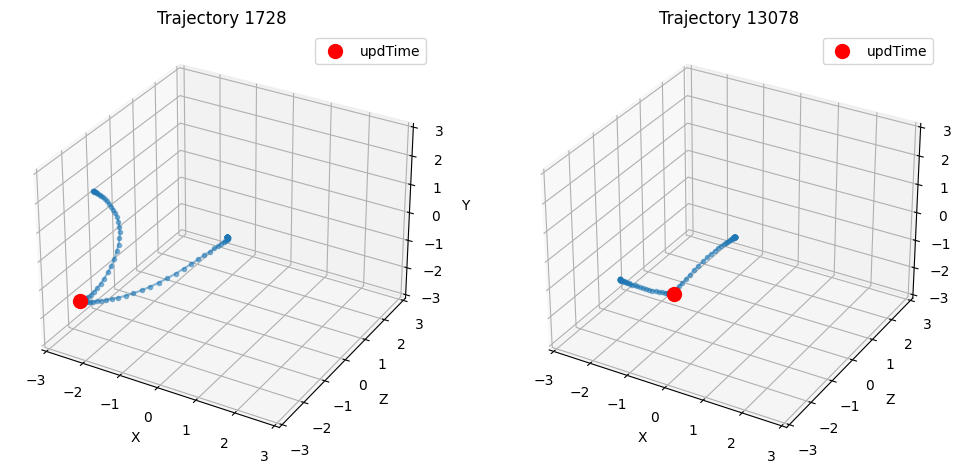

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_trajectory(ax, df_plot):
    ax.plot(df_plot['rotation_x'], df_plot['rotation_y'], df_plot['rotation_z'], marker='o', alpha=0.5, markersize=3)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-3, 3)
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    # Add updTime point if available
    if pd.notna(df_plot['updTime'].iloc[0]) and pd.notna(df_plot['update_time'].iloc[0]):
        try:
            closesnt_index = np.abs(df_plot['time_milisecond'] - (df_plot["stop_turn_miliseconds"].iloc[0])).idxmin()
            print(f'closest index is {closesnt_index}')
            print(f'closest time is {df_plot["time_milisecond"].loc[closesnt_index]:.2f}')
            print(f'x: {df_plot["rotation_x"].loc[closesnt_index]:.2f}')
            print(f'y: {df_plot["rotation_y"].loc[closesnt_index]:.2f}')
            print(f'z: {df_plot["rotation_z"].loc[closesnt_index]:.2f}')
            ax.scatter(df_plot['rotation_x'].loc[closesnt_index], 
                      df_plot['rotation_y'].loc[closesnt_index], 
                      df_plot['rotation_z'].loc[closesnt_index], 
                      color='red', s=100, label='updTime', alpha=1)
            ax.legend()
        except Exception as e:
            print(f"Error adding updTime point: {e}")

id_for_plot = np.random.choice(ids_with_updTime, size=2, replace=False)
fig = plt.figure(figsize=(12, 6))
for i, idx in enumerate(id_for_plot):
    ax = fig.add_subplot(1, 2, i + 1, projection='3d')
    # Extract the DataFrame for the current trajectory
    df_plot = df_rotation[df_rotation['id'] == idx]
    plot_trajectory(ax, df_plot)
    ax.set_title(f'Trajectory {idx}')

plt.show()


In [30]:
def map_targets_to_angle(id_target, id_update):
    """
    Maps target IDs to angles.
    """
    if not pd.isna(id_update):
        old_target, new_target = round(id_target), round(id_update)
        if not np.isnan(new_target):
            target_diff = abs(new_target - old_target)
            # Adjust for circular nature of targets.
            if target_diff > 4:
                target_diff = 8 - target_diff
            angle_map = {1: 45, 2: 90, 3: 135, 4: 180}
            return angle_map.get(target_diff, 0)
    else:
        return 0

#14. Add type_angle_jump_trajectory
df_rotation['type_trajectory'] = df_rotation.apply(lambda row: map_targets_to_angle(row['id_target'], row['id_update']), axis=1)

In [31]:
def calc_points(group):
    """
    Calculate the angles between consecutive triplets of points in the group.
    """
    group['point'] = list(zip(group['rotation_x'], group['rotation_y'], group['rotation_z']))
    angles = []
    for i in range(len(group) - 2):
        A = group['point'].iloc[i]
        B = group['point'].iloc[i + 1]
        C = group['point'].iloc[i + 2]
        angle = angle_between_three_points(A, B, C)
        angles.append(angle)
    # Add NaN for the last two points as they don't have enough subsequent points for the angle calculation
    angles.extend([np.nan, np.nan])
    group['angle'] = angles
    return group

def angle_between_three_points(A, B, C):
    # Convert points to numpy arrays
    A = np.array(A)
    B = np.array(B)
    C = np.array(C)
    # Calculate vectors AB and BC
    AB = B - A
    BC = C - B
    # Calculate the dot product and magnitudes of AB and BC
    dot_product = np.dot(AB, BC)
    magnitude_AB = np.linalg.norm(AB)
    magnitude_BC = np.linalg.norm(BC)
    # Calculate the cosine of the angle
    cos_angle = dot_product / (magnitude_AB * magnitude_BC)
    # Handle potential numerical issues
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    # Calculate the angle in radians
    angle_radians = np.arccos(cos_angle)
    # Convert the angle to degrees
    angle_degrees = np.degrees(angle_radians)
    return angle_degrees

# Example DataFrame (Assuming df_rotation is your DataFrame with rotated trajectories)
df_features_angle = df_rotation.groupby('id').apply(calc_points)
df_features_angle.reset_index(drop=True, inplace=True)

/var/folders/_g/3z75f6712896hmqgg1jt1t9h0000gn/T/ipykernel_80000/2585424187.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features_angle = df_rotation.groupby('id').apply(calc_points)


In [32]:
def calculate_relative_angle_to_end(group):
    # End coordinates
    end_x, end_y, end_z = group['rotation_x'].iloc[-1], group['rotation_y'].iloc[-1], group['rotation_z'].iloc[-1]
    # Differences to the end point
    delta_x_to_end = end_x - group['rotation_x']
    delta_y_to_end = end_y - group['rotation_y']
    delta_z_to_end = end_z - group['rotation_z']
    
    # Start coordinates
    start_x, start_y, start_z = group['rotation_x'].iloc[0], group['rotation_y'].iloc[0], group['rotation_z'].iloc[0]
    
    # Differences from start to end
    delta_x_start_to_end = end_x - start_x
    delta_y_start_to_end = end_y - start_y
    delta_z_start_to_end = end_z - start_z
    
    # Calculate angles in 3D space
    angle_to_end_xy = np.arctan2(delta_y_to_end, delta_x_to_end)  # Angle in XY plane
    angle_to_end_xz = np.arctan2(delta_z_to_end, delta_x_to_end)  # Angle in XZ plane
    angle_to_end_yz = np.arctan2(delta_z_to_end, delta_y_to_end)  # Angle in YZ plane
    
    angle_start_to_end_xy = np.arctan2(delta_y_start_to_end, delta_x_start_to_end)
    angle_start_to_end_xz = np.arctan2(delta_z_start_to_end, delta_x_start_to_end)
    angle_start_to_end_yz = np.arctan2(delta_z_start_to_end, delta_y_start_to_end)
    
    # Calculate relative angles in each plane
    relative_angle_xy = np.degrees(angle_to_end_xy - angle_start_to_end_xy)
    relative_angle_xz = np.degrees(angle_to_end_xz - angle_start_to_end_xz)
    relative_angle_yz = np.degrees(angle_to_end_yz - angle_start_to_end_yz)
    
    # Normalize angles to the range [-180, 180]
    relative_angle_xy = (relative_angle_xy + 180) % 360 - 180
    relative_angle_xz = (relative_angle_xz + 180) % 360 - 180
    relative_angle_yz = (relative_angle_yz + 180) % 360 - 180
    
    # Store results in the DataFrame
    group['angle_to_end_xy'] = relative_angle_xy
    group['angle_to_end_xz'] = relative_angle_xz
    group['angle_to_end_yz'] = relative_angle_yz
    
    # Calculate the Euclidean distance to the end point in 3D space
    group['distance_to_end'] = np.sqrt((group['rotation_x'] - end_x)**2 + 
                                       (group['rotation_y'] - end_y)**2 + 
                                       (group['rotation_z'] - end_z)**2)
    
    return group

# Apply the function to the DataFrame
df_features_angle_to_end = df_features_angle.groupby('id').apply(calculate_relative_angle_to_end)
df_features_angle_to_end.reset_index(drop=True, inplace=True)

/var/folders/_g/3z75f6712896hmqgg1jt1t9h0000gn/T/ipykernel_80000/1517213006.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features_angle_to_end = df_features_angle.groupby('id').apply(calculate_relative_angle_to_end)


In [33]:
def fill_events_columns(df):
    """
    Fills the event columns based on the closest time points and updates label maps and lists.
    """
    events = ['normalized_start_movement', 'normalized_stop_turn']
    label_maps = {key: {} for key in ['nonrmalized_start_move_point', 'normalized_stop_turn_point']}
    
    for traj_id in df['id'].unique():
        trial = df[df['id'] == traj_id]
        if trial.empty:
            continue  # Skip empty subsets
        
        for event in events:
            if event not in trial.columns:
                continue  # Skip if event column is missing
            event_time = trial.iloc[0][event]
            if pd.isna(event_time):
                continue  # Skip if event_time is NaN or zero
            closest_point_idx = (trial['normalized_time'] - event_time).abs().idxmin()
            
            normalized_time = trial.at[closest_point_idx, 'normalized_time']
            if event == 'normalized_start_movement':
                label_maps['nonrmalized_start_move_point'][traj_id] = normalized_time
            elif event == 'normalized_stop_turn' and not pd.isna(trial.iloc[0]['updTime']):
                label_maps['normalized_stop_turn_point'][traj_id] = normalized_time
    return label_maps
label_maps = fill_events_columns(df_features_angle_to_end)

start_move = label_maps['nonrmalized_start_move_point']
stop_turn = label_maps['normalized_stop_turn_point']

In [34]:
df_features_angle_to_end['id'].nunique(), len(start_move), len(stop_turn)

(13335, 13335, 1975)

In [35]:
if monkey_name=='nana':
    with open('../Features/Features_nana', 'wb') as f:
        pickle.dump((df_features_angle_to_end,start_move,stop_turn), f)
else:
    with open('../Features/Features_thina', 'wb') as f:
        pickle.dump((df_features_angle_to_end,start_move,stop_turn), f)